# Gradually increase the n_sats 

In [1]:
import numpy as np
import pygmo as pg
from modules.golomb_problem import init_medium_problem, orbital_golomb_array, compute_unique_distances_and_sats_in_grid
from modules.gradually_increase_difficulty import increase_difficulty

INCREASE_N_SATS = range(5, 41, 5)
UDP = init_medium_problem()

def get_n_iteration(n_sats: int, force_golomb : bool = False):
    if force_golomb :
        return int(n_sats * 6 * 10 * 1.5)
    return n_sats * 6 * 10 

def get_population_size(n_sats: int):
    return n_sats * 6 * 3

***Lanciando `optimizer()` ricorda di passare `file_name` cosi da poter salvare le soluzioni trovate nel caso servano dei plot***

##### Template

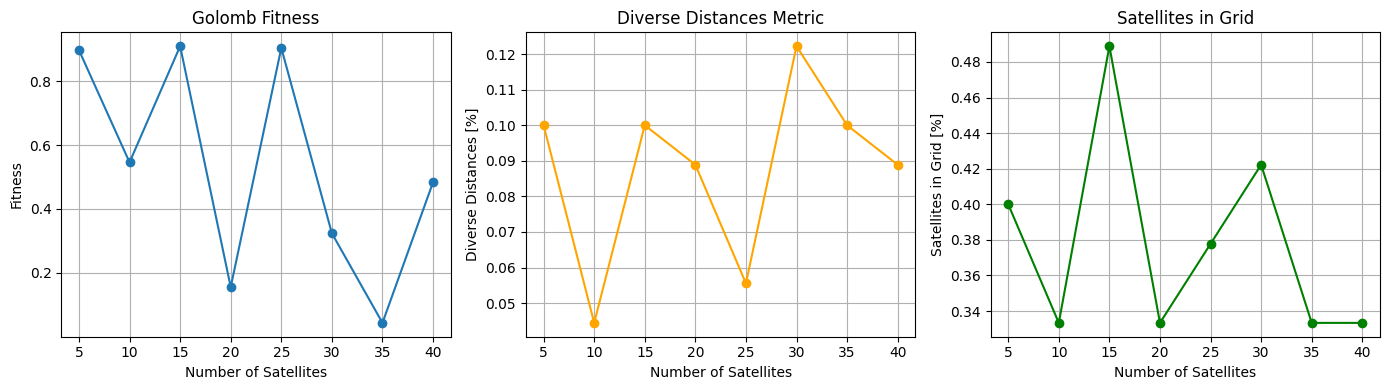

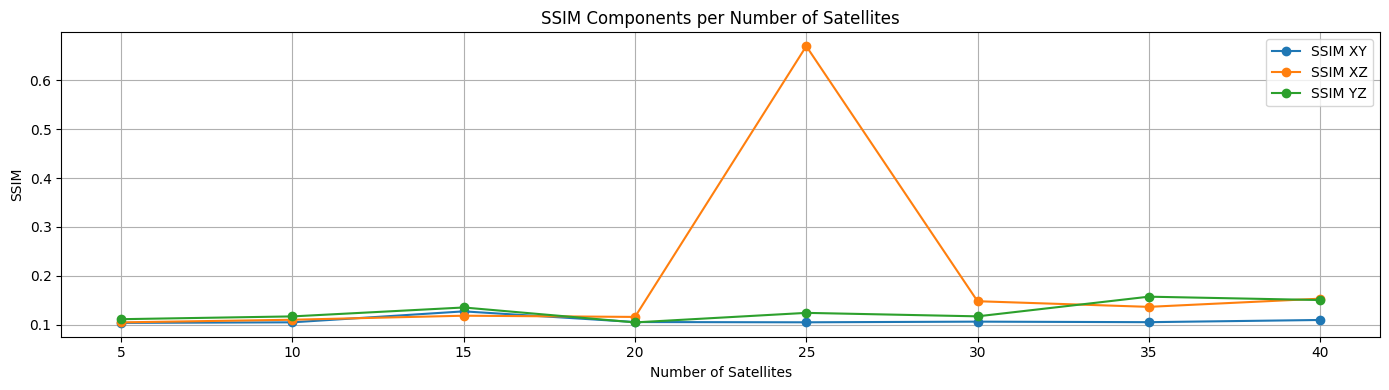

| N_sats | Original Fitness | Diverse Distances [%] | Satellites in Grid [%] | SSIM (xy,xz,yz) [%] | 
|---|---|---|---| --- |
| 5 | 0.8970 | 10.00 | 40.00 | [10.38, 10.48, 11.13] |
| 10 | 0.5459 | 4.44 | 33.33 | [10.49, 11.02, 11.7] |
| 15 | 0.9095 | 10.00 | 48.89 | [12.73, 11.84, 13.53] |
| 20 | 0.1555 | 8.89 | 33.33 | [10.55, 11.6, 10.48] |
| 25 | 0.9041 | 5.56 | 37.78 | [10.5, 66.97, 12.43] |
| 30 | 0.3239 | 12.22 | 42.22 | [10.63, 14.81, 11.71] |
| 35 | 0.0435 | 10.00 | 33.33 | [10.52, 13.65, 15.74] |
| 40 | 0.4835 | 8.89 | 33.33 | [10.97, 15.33, 15.05] |


In [4]:
def optimizer(udp: orbital_golomb_array) -> tuple[float, list[float]]:
    import time
    import random
    
    print("amongoose")
    print("n_sats = ", udp.n_sat)
    time.sleep(1)

    return (random.random(), [random.random() for i in range(0, udp.n_sat * 6)])

ret = increase_difficulty(UDP, INCREASE_N_SATS, optimizer, file_name=None, verbose=True)
del ret

## Non-Dominated Sorting Genetic Algorithm

In [6]:
class GolombOptimization:
    def __init__(self, udp, n_sat):
        """
        Classe che rappresenta il problema multi-obiettivo.
        udp: il problema originale esistente.
        n_sat: numero di satelliti.
        """
        self.udp = udp
        self.n_var = n_sat * 6  # Numero di variabili (6 per satellite)
        self.n_obj = 4  # Numero di obiettivi
        self.bounds = ([-1] * self.n_var, [1] * self.n_var)  # Limiti per le variabili

    def fitness(self, x):
        """
        Calcola le fitness:
        - f1, f2, f3: Fattori di riempimento ai tre istanti temporali.
        - f4: Numero normalizzato di distanze uniche tra i satelliti.
        """
        # Calcola i fattori di riempimento ai 3 istanti temporali
        fill_factors = self.udp.fitness_impl(x, plotting=False, return_all_n_meas_fillfactor=True)
        if len(fill_factors) < 3:
            raise ValueError("La funzione fitness_impl non ha restituito almeno 3 valori.")
        f1, f2, f3 = fill_factors[:3]

        # Calcola f4: Numero normalizzato di distanze uniche
        distances_score, _ = compute_unique_distances_and_sats_in_grid(self.udp, x)
        f4 = -distances_score  # Minimizzazione del punteggio delle distanze uniche

        return [f1, f2, f3, f4]  # Restituisce le 4 fitness

    def get_bounds(self):
        return self.bounds

    def get_nobj(self):
        return self.n_obj

# Ottimizzatore basato su NSGA-II
def nsga2_optimizer(udp: orbital_golomb_array, n_sats: int):
    """
    Configura ed esegue l'ottimizzazione NSGA-II per il numero dato di satelliti.
    udp: problema esistente da ottimizzare.
    n_sats: numero di satelliti.
    """

    problem = pg.problem(GolombOptimization(udp, n_sats))
    algorithm = pg.algorithm(pg.nsga2(gen=100))  # Numero di generazioni: 100
    population = pg.population(problem, size=300)  # Dimensione della popolazione

    # Esegui l'evoluzione
    population = algorithm.evolve(population)

    # Estrai il fronte di Pareto
    pareto_fitness = population.get_f()  # Fitness delle soluzioni di Pareto
    pareto_vectors = population.get_x()  # Variabili di decisione delle soluzioni di Pareto

    # Trova la soluzione migliore rispetto al primo obiettivo
    best_idx = np.argmin(pareto_fitness[:, 0])  # Indice della soluzione migliore
    best_solution = pareto_vectors[best_idx]  # Variabili della soluzione migliore
    best_fitness = pareto_fitness[best_idx][0]  # Valore del primo obiettivo per la soluzione migliore

    return best_fitness, best_solution

# Funzione per aumentare gradualmente la difficoltà
def increase_difficulty(udp, n_sats_range, optimizer):
    """
    Esegue l'ottimizzazione per una gamma crescente di difficoltà.
    udp: problema da ottimizzare.
    n_sats_range: intervallo di numeri di satelliti da considerare.
    optimizer: funzione di ottimizzazione.
    """
    results = []
    for n_sats in n_sats_range:
        print(f"Ottimizzazione con {n_sats} satelliti...")
        best_fitness, best_solution = optimizer(udp, n_sats)
        results.append((n_sats, best_fitness, best_solution))
        print(f"Miglior fitness per {n_sats} satelliti: {best_fitness}")
    return results

_ = increase_difficulty(UDP, INCREASE_N_SATS, nsga2_optimizer, file_name="NSGA2")

Ottimizzazione con 5 satelliti...
Miglior fitness per 5 satelliti: -0.14285714285714285
Ottimizzazione con 10 satelliti...
Miglior fitness per 10 satelliti: -0.14285714285714285
Ottimizzazione con 15 satelliti...
Miglior fitness per 15 satelliti: -0.14285714285714285
Ottimizzazione con 20 satelliti...
Miglior fitness per 20 satelliti: -0.14285714285714285
Ottimizzazione con 25 satelliti...
Miglior fitness per 25 satelliti: -0.14285714285714285
Ottimizzazione con 30 satelliti...
Miglior fitness per 30 satelliti: -0.14285714285714285
Ottimizzazione con 35 satelliti...
Miglior fitness per 35 satelliti: -0.14285714285714285


## Grey Wolf

## Differencial Evolution

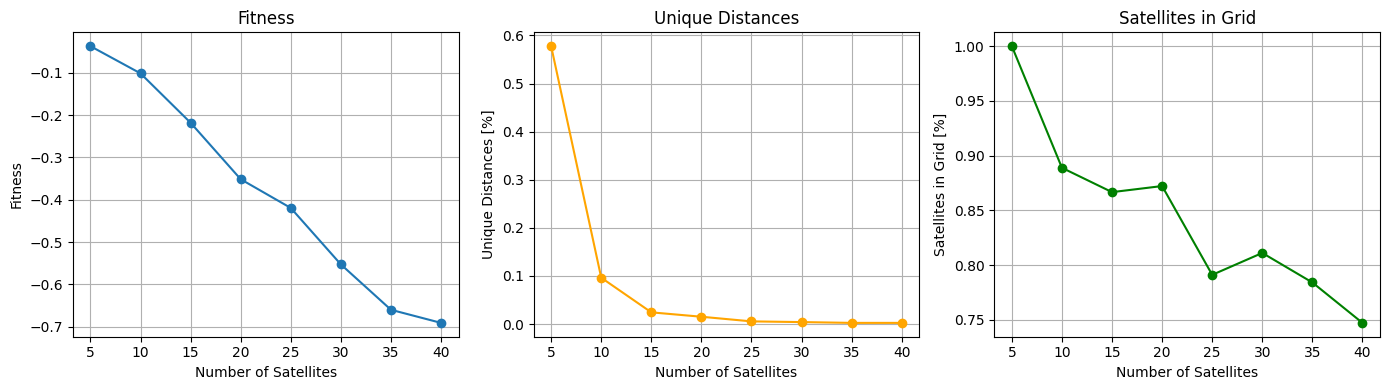

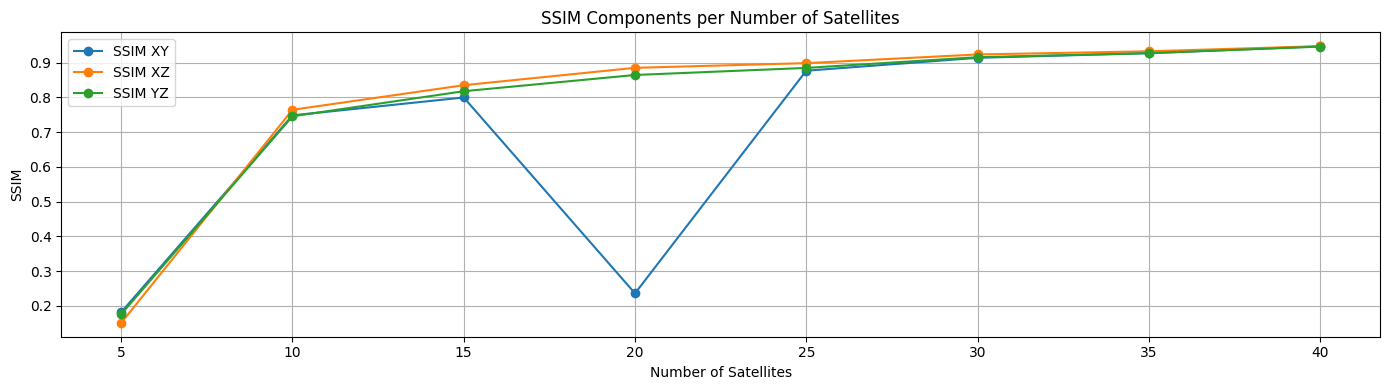

| N_sats | Original fitness | Unique distances [%] | Satellites in grid [%] | SSIM (xy,xz,yz) [%] | 
|---|---|---|---| --- |
| 5 | -0.03747769185008923 | 57.78 | 100.00 | [18.15, 15.08, 17.6] |
| 10 | -0.10172516359309933 | 9.63 | 88.89 | [74.8, 76.4, 74.54] |
| 15 | -0.2183224271267103 | 2.43 | 86.67 | [79.95, 83.48, 81.75] |
| 20 | -0.35157644259369425 | 1.52 | 87.22 | [23.57, 88.48, 86.42] |
| 25 | -0.41939321832242715 | 0.56 | 79.11 | [87.65, 89.83, 88.46] |
| 30 | -0.552647233789411 | 0.41 | 81.11 | [91.36, 92.33, 91.54] |
| 35 | -0.6597263533610946 | 0.24 | 78.41 | [92.7, 93.24, 92.7] |
| 40 | -0.6906603212373588 | 0.24 | 74.72 | [94.67, 94.71, 94.58] |


In [ ]:
def optimizer(udp: orbital_golomb_array) -> tuple[float, list[float]]:
    algo = pg.algorithm(
        pg.de1220(
            gen=get_n_iteration(udp.n_sat,False), 
            allowed_variants=[i for i in range(1, 19)],
            variant_adptv=1,
            ftol=0,
            xtol=0, 
            memory=False
        ),
    )
    algo.set_verbosity(2)

    evolve = algo.evolve(
        pg.population(
            pg.problem(udp), 
            size=get_population_size(udp.n_sat)
            )
        )
    return evolve.champion_f[0], evolve.champion_x

result = increase_difficulty(UDP, INCREASE_N_SATS, optimizer, file_name="differential_evolution", verbose=True)

In [ ]:
def optimizer(udp: orbital_golomb_array) -> tuple[float, list[float]]:
    algo = pg.algorithm(
        pg.de1220(
            gen=int(get_n_iteration(udp.n_sat, False)*1.5), 
            allowed_variants=[i for i in range(1, 19)],
            variant_adptv=1,
            ftol=0,
            xtol=0, 
            memory=False
        ),
    )
    algo.set_verbosity(2)

    evolve = algo.evolve(
        pg.population(
            pg.problem(udp), 
            size=get_population_size(udp.n_sat)
            )
        )
    return evolve.champion_f[0], evolve.champion_x

result = increase_difficulty(UDP, range(5,11), optimizer, file_name="differential_evolution_5_10")